In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
uploaded=files.upload()

Saving OnlineRetail[1].csv to OnlineRetail[1] (1).csv


In [53]:
df=pd.read_csv("OnlineRetail[1].csv", encoding='latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### Why do we see the same CustomerID and InvoiceNo repeated with different StockCode?

In this dataset, each row represents an individual line item in a retail transaction.  
That means an invoice (InvoiceNo) may contain multiple different products (StockCode).  

Example:
- A customer buys 3 different items in one order → this creates 3 rows with:
  - The same CustomerID (the buyer)
  - The same InvoiceNo (the same order)
  - Different StockCode (different products)

So seeing multiple rows like:
- CustomerID: 17850
- InvoiceNo: 573021
- StockCode: 85123A / 21094 / 22423

is completely normal and expected in real business transaction data.

### Key Meaning:
- **InvoiceNo = One actual order**
- **StockCode = Different products within the same order**
- **Quantity & UnitPrice apply per product line**
- **`df` is a line-item level dataset, not order summary level**

This structure is useful because it allows analysis such as:
- RFM segmentation (customer behavior)
- Basket size & product affinity (market basket analysis)
- Total order value = sum of product line amounts
- Product-level clustering in future


In [54]:
print("Data shape:", df.shape)
df.info()
df.isnull().sum()

Data shape: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [55]:
df = df.dropna(subset=["CustomerID"])
df["CustomerID"] = df["CustomerID"].astype(int)
df = df.dropna(subset=["Description"])
print("datashape:", df.shape)
print("total null:",df.isnull().sum().sum())


for column in df.select_dtypes(include='number').columns:
    df = df[(df[column] > 0)]


datashape: (406829, 8)
total null: 0


<Axes: xlabel='UnitPrice'>

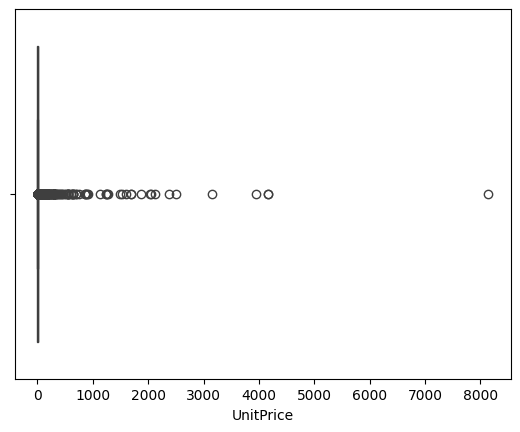

In [56]:
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
sns.boxplot(x=df["UnitPrice"])



Outliers in e-commerce are real customers, usually not errors
(e.g., wholesale buyers, corporate bulk orders, VIP spenders).

Removing them would erase important buying patterns.

Our models (KMeans + Random Forest) handled outliers well:

KMeans created clear segments

Random Forest still gave strong R² and low errors

## Reference date and sales column formation

In [57]:

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%d-%m-%Y %H:%M")

reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
print(reference_date)
df['Sales'] = df['Quantity'] * df['UnitPrice']



2011-12-10 12:50:00


### RFM ( customer-level ) dataframe

In [58]:

reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg(
    Recency = ('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency = ('InvoiceNo', 'nunique'),
    Monetary = ('Sales', 'sum')
).reset_index()

rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


### Silhouette score check for cluster

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


#  Scale only numeric RFM data

x = rfm[["Recency", "Frequency", "Monetary"]]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


# Find the best K using silhouette score
print("Silhouette Scores for Different K:")
best_k = None
best_score = -1

for k in range(2, 11):
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    test_labels = kmeans_test.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, test_labels)
    print(f"k={k}, Silhouette Score={score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k
print(f"\nBest K based on silhouette score is: {best_k}")

Silhouette Scores for Different K:
k=2, Silhouette Score=0.8958
k=3, Silhouette Score=0.5942
k=4, Silhouette Score=0.6162
k=5, Silhouette Score=0.6165
k=6, Silhouette Score=0.5963
k=7, Silhouette Score=0.5165
k=8, Silhouette Score=0.5175
k=9, Silhouette Score=0.4777
k=10, Silhouette Score=0.4271

Best K based on silhouette score is: 2


###WCSS Loop (Elbow Method)

k=2, WCSS=9012.64
k=3, WCSS=5439.30
k=4, WCSS=4092.14
k=5, WCSS=3118.28
k=6, WCSS=2472.57
k=7, WCSS=2022.41
k=8, WCSS=1742.37
k=9, WCSS=1445.63
k=10, WCSS=1303.39


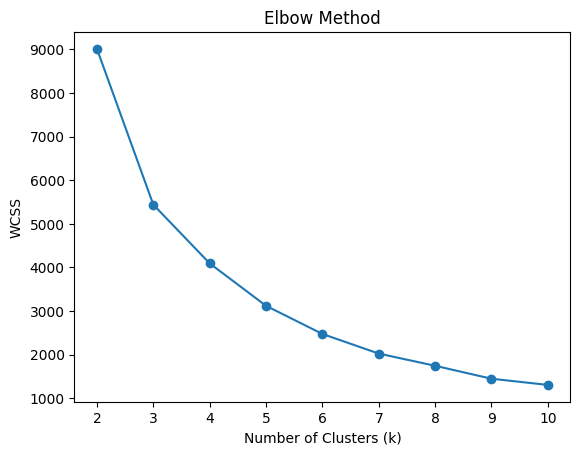

In [60]:
from sklearn.cluster import KMeans

wcss = []

for k in range(2, 11):
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(x_scaled)
    wcss.append(kmeans_test.inertia_)   # inertia_ = WCSS

    print(f"k={k}, WCSS={kmeans_test.inertia_:.2f}")


plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()


## Cluster visualization

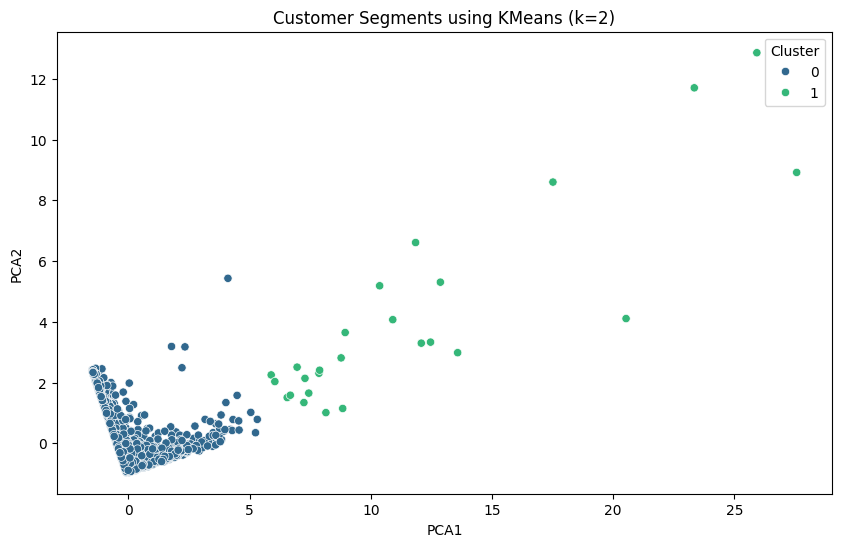

In [61]:

 #3. Train final KMeans using best k

km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = km.fit_predict(x_scaled)
rfm["Cluster"] = labels


# 4. PCA for Visualization

pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_scaled)

rfm["PCA1"] = pca_result[:, 0]
rfm["PCA2"] = pca_result[:, 1]

# 5. Plot clusters on PCA space

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x="PCA1", y="PCA2", hue="Cluster", palette="viridis")
plt.title(f"Customer Segments using KMeans (k={best_k})")
plt.show()

### Centroids

In [62]:
real_centroids=scaler.inverse_transform(km.cluster_centers_)
pd.DataFrame(real_centroids, columns=x.columns)


,Recency,Frequency,Monetary
0,93.057978,3.897263,1548.676893
1,6.038462,66.423077,85904.351538


### Customer segment clustering

In [63]:
rfm["Segment"] = rfm["Cluster"].map({
    0: "Low Value / At-Risk Customers",
    1: "High Value / VIP Customers"
})

rfm["Segment"]

,Segment
0,Low Value / At-Risk Customers
1,Low Value / At-Risk Customers
2,Low Value / At-Risk Customers
3,Low Value / At-Risk Customers
4,Low Value / At-Risk Customers
...,...
4333,Low Value / At-Risk Customers
4334,Low Value / At-Risk Customers
4335,Low Value / At-Risk Customers
4336,Low Value / At-Risk Customers


##Visualize Cluster Centers (Heatmap)

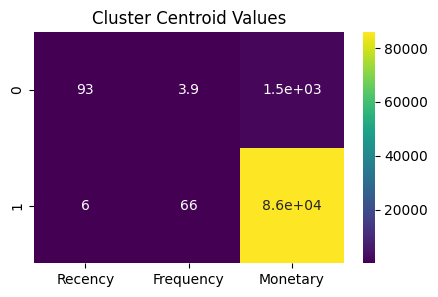

In [64]:
import seaborn as sns
plt.figure(figsize=(5,3))
sns.heatmap(pd.DataFrame(real_centroids, columns=["Recency","Frequency","Monetary"]),
            annot=True, cmap="viridis")
plt.title("Cluster Centroid Values")
plt.show()


## Predictive analysis for customers for each cluster

In [65]:
# SCALE FOR CLUSTERING
scaler_kmeans = StandardScaler()
rfm_scaled = scaler_kmeans.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

# K-MEANS CLUSTERING
kmeans = KMeans(n_clusters=2, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)


Used two scalers because the first scaler was only for PCA
visualization. It was not used for clustering.

The second scaler (scaler_kmeans) is the actual scaler used for
KMeans clustering and is also used during prediction.

Therefore, prediction must use scaler_kmeans, not the PCA scaler.


In [66]:
# Feature engineering for prediction
# Aggregated product features from df

customer_features = df.groupby('CustomerID').agg(
    TotalQuantity=('Quantity','sum'),
    UniqueProducts=('StockCode','nunique')
).reset_index()

rfm = pd.merge(rfm, customer_features, on='CustomerID', how='left')
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

rfm[['CustomerID','Recency','Frequency','Monetary','TotalQuantity','UniqueProducts','AvgOrderValue','Cluster']].head()

,CustomerID,Recency,Frequency,Monetary,TotalQuantity,UniqueProducts,AvgOrderValue,Cluster
0,12346,326,1,77183.60,74215,1,77183.600000,1
1,12347,2,7,4310.00,2458,103,615.714286,0
2,12348,75,4,1797.24,2341,22,449.310000,0
3,12349,19,1,1757.55,631,73,1757.550000,0
4,12350,310,1,334.40,197,17,334.400000,1


Scaled only 3 features (Recency, Frequency, Monetary) for KMeans because these are the RFM features used for customer clustering.

The other engineered features (TotalQuantity, UniqueProducts, AvgOrderValue)
are used later for prediction, not for clustering. They are scaled separately
inside the regression models.

So clustering uses 3 scaled features, while prediction uses 5 scaled features.


In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

#  Make the clusters
kmeans = KMeans(n_clusters=2, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# See how many customers in each cluster
print(rfm["Cluster"].value_counts())

Cluster
0    3237
1    1101
Name: count, dtype: int64


## Model Training per Cluster

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Features used for prediction
features = ["Recency", "Frequency", "TotalQuantity", "UniqueProducts", "AvgOrderValue"]

# Dictionary to store RF model for each cluster
rf_models = {}

for cluster in rfm["Cluster"].unique():

    print("\n===============================")
    print("Training Random Forest for Cluster:", cluster)
    print("===============================\n")

    cluster_data = rfm[rfm["Cluster"] == cluster]

    x = cluster_data[features]
    y = cluster_data["Monetary"]

    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    # Scaling
    scaler = StandardScaler()
    x_train_s = scaler.fit_transform(x_train)
    x_test_s = scaler.transform(x_test)

    # Random Forest model
    rf = RandomForestRegressor(random_state=42)
    rf.fit(x_train_s, y_train)
    y_pred = rf.predict(x_test_s)

    # Evaluation metrics
    r2  = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print("R² :", round(r2, 4))
    print("MSE:", round(mse, 2))
    print("MAE:", round(mae, 2))




Training Random Forest for Cluster: 1

R² : 0.7858
MSE: 135128.5
MAE: 91.31

Training Random Forest for Cluster: 0

R² : 0.826
MSE: 25872159.65
MAE: 584.3


##Random Forest Regressor
Works well with raw, messy, skewed, real-world datasets
Robust to outliers (unlike Linear Regression)
Captures complex relationships between:
Quantity,
Frequency,
Product variety,
Avg order value,

Performed best in cluster-wise evaluation:
Highest R²,
Lowest errors



### Stored the model and scaler for prediction use

In [69]:
rf_models[cluster] = {
        "model": rf,
        "scaler": scaler
    }

## Prediction Functions

In [70]:
def predict_customer_value(recency, frequency, total_quantity, unique_products, average_order_value):

    # 1. Compute monetary for cluster prediction
    monetary = average_order_value * frequency

    # 2. Predict cluster
    cluster_input = pd.DataFrame(
        [[recency, frequency, monetary]],
        columns=["Recency", "Frequency", "Monetary"]
    )

    cluster_scaled = scaler_kmeans.transform(cluster_input)
    cluster_no = kmeans.predict(cluster_scaled)[0]

    print("Customer belongs to Cluster:", cluster_no)

    # 3. Prepare features for monetary prediction
    new_customer = pd.DataFrame(
        [[recency, frequency, total_quantity, unique_products, average_order_value]],
        columns=["Recency","Frequency","TotalQuantity","UniqueProducts","AvgOrderValue"]
    )

    # 4. Scale using cluster-specific scaler
    selected_scaler = rf_models[cluster_no]["scaler"]
    selected_model  = rf_models[cluster_no]["model"]

    new_scaled = selected_scaler.transform(new_customer)

    # 5. Predict monetary
    predicted_value = selected_model.predict(new_scaled)[0]
    print("Predicted Monetary Value:", round(predicted_value, 2))


### Unkown customer prediction

In [71]:
predict_customer_value(
    recency = 20,
    frequency = 12,
    total_quantity = 200,
    unique_products = 10,
    average_order_value = 300)



Customer belongs to Cluster: 0
Predicted Monetary Value: 929.41
